In [2]:
from point2vec.models import PointMAE
from glob import glob
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

def get_newest_ckpt(ckpt_path):
    ckpt_path = glob(f'{ckpt_path}/**/*.ckpt')
    newest_ckpt = max(ckpt_path, key=os.path.getctime)
    return newest_ckpt

wandb_run_id = 'fjnp0snd'
ckpt_path = f'/sdf/home/y/youngsam/sw/dune/representations/point2vec/PointMAE-Pretraining-LArNet-5voxel/{wandb_run_id}'

model = PointMAE.load_from_checkpoint(
    get_newest_ckpt(ckpt_path)
).cuda()
model.eval();

/sdf/home/y/youngsam/sw/dune/.conda/envs/py310/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

I assume you have already run `00_dataset.ipynb` and `01_tokenization.ipynb` and have the dataset format/tokenization scheme understood.

# Dataset Initialization

In [6]:
from point2vec.datasets import LArNetDataModule
import matplotlib.pyplot as plt
import torch
import numpy as np
torch.set_grad_enabled(False)

In [29]:
import torch.nn as nn
from point2vec.modules.transformer import TransformerEncoder, TransformerEncoderOutput
from point2vec.modules.masking import VariablePointcloudMasking
from point2vec.modules.pointnet import PointcloudTokenizer

# Tokenizer ================================
tokenizer_num_init_groups: int = 512
tokenizer_context_length: int = 480
tokenizer_group_size: int = 32
tokenizer_group_radius: float | None = 5 / 760
tokenizer_upscale_group_size: int | None = 2048
tokenizer_overlap_factor: float | None = 2.0
tokenizer_reduction_method: str = "fps"

encoder_dim: int = 384
num_channels: int = 4
embedding_type: str = "masked_mini"

tokenizer = PointcloudTokenizer(
            num_init_groups=tokenizer_num_init_groups,
            context_length=tokenizer_context_length,
            group_size=tokenizer_group_size,
            group_radius=tokenizer_group_radius,
            upscale_group_size=tokenizer_upscale_group_size,
            reduction_method=tokenizer_reduction_method,
            overlap_factor=tokenizer_overlap_factor,
            token_dim=encoder_dim,
            num_channels=num_channels,
            embedding_type=embedding_type,
        ).cuda()


# Masking ================================
# Mask 60% of tokens randomly
masking = VariablePointcloudMasking(
    ratio=0.6,
    type='rand'
)

# Learnable Mask Token ================================
mask_token = nn.Parameter(torch.zeros(encoder_dim)).cuda()
nn.init.trunc_normal_(mask_token, mean=0, std=0.02, a=-0.02, b=0.02)


# Transformer Encoder ================================
# Encodes visible (unmasked) tokens
encoder_dim: int = 384
encoder_depth: int = 12
encoder_heads: int = 6
encoder_dropout: float = 0
encoder_attention_dropout: float = 0.05
encoder_drop_path_rate: float = 0.25
encoder_add_pos_at_every_layer: bool = True
encoder_qkv_bias: bool = True

dpr = [
    x.item() for x in torch.linspace(0, encoder_drop_path_rate, encoder_depth)
]


encoder = TransformerEncoder(
    embed_dim=encoder_dim,
    depth=encoder_depth,
    num_heads=encoder_heads,
    qkv_bias=encoder_qkv_bias,
    drop_rate=encoder_dropout,
    attn_drop_rate=encoder_attention_dropout,
    drop_path_rate=dpr,
    add_pos_at_every_layer=encoder_add_pos_at_every_layer,
).cuda()

# Transformer Decoder ================================
# Decodes masked tokens into guesses of what they should be using encoder outputs
decoder_depth: int = 4
decoder_dropout: float = 0
decoder_attention_dropout: float = 0.05
decoder_drop_path_rate: float = 0.25
decoder_add_pos_at_every_layer: bool = True
decoder_qkv_bias: bool = True

decoder_dpr = [
    x.item() for x in torch.linspace(0, decoder_drop_path_rate, decoder_depth)
]

decoder = TransformerEncoder(
    embed_dim=encoder_dim,
    depth=decoder_depth,
    num_heads=encoder_heads,
    qkv_bias=decoder_qkv_bias,
    drop_rate=decoder_dropout,
    attn_drop_rate=decoder_attention_dropout,
    drop_path_rate=decoder_dpr,
    add_pos_at_every_layer=decoder_add_pos_at_every_layer,
).cuda()

# Increase Dimension ================================
# Regresses a fixed set of 4D points from one token
increase_dim = nn.Sequential(
    nn.Conv1d(encoder_dim, num_channels*tokenizer_group_size, 1),
).cuda()

# Positional Encoding ================================
# Encodes the 3D position of patch centers to add onto token embeddings before passing into encoder
positional_encoding = nn.Sequential(
    nn.Linear(3, 128),
    nn.GELU(),
    nn.Linear(128, encoder_dim),
).cuda()

In [30]:
dataset = LArNetDataModule(
    data_path=f'/sdf/home/y/youngsam/data/dune/larnet/h5/DataAccessExamples/train/generic_v2*.h5',
    batch_size=24,
    num_workers=0,
    dataset_kwargs={
        'emin': 1.0e-6,                      # min energy for log transform
        'emax': 20.0,                        # max energy for log transform
        'energy_threshold': 0.13,            # remove points with energy < 0.13
        'remove_low_energy_scatters': True,  # remove low energy scatters (PID=4)
        'maxlen': -1,                        # max number of events to load
        'normalize': True,                   # normalize point cloud to unit sphere
    }
)
dataset.setup()

# DataLoader
train_loader = dataset.train_dataloader()

# Inference
for batch in train_loader:
    points, lengths, semantic_id, endpoints = batch
    points = points.cuda()
    lengths = lengths.cuda()
    break

[DATASET] self.emin=1e-06, self.emax=20.0, self.energy_threshold=0.13, self.normalize=True, self.remove_low_energy_scatters=True
[DATASET] Building index
[DATASET] 864064 point clouds were loaded
[DATASET] 10 files were loaded
[DATASET] self.emin=1e-06, self.emax=20.0, self.energy_threshold=0.13, self.normalize=True, self.remove_low_energy_scatters=True
[DATASET] Building index
[DATASET] 8531 point clouds were loaded
[DATASET] 1 files were loaded


# Training step example

In [40]:
# Group & tokenize point cloud
(
    embeddings,
    centers,
    embedding_mask,
    semantic_id_groups,
    endpoints_groups,
    groups,
    point_mask,
) = tokenizer(points, lengths, return_point_info=True)


# Mask 60% of tokens
masked, unmasked = masking(centers, embedding_mask.sum(-1))

Below shows the masked and unmasked token masks for each event in the batch. You'll see only 60% of the unpadded tokens per event are masked, and that masked + unmasked = embedding_mask.

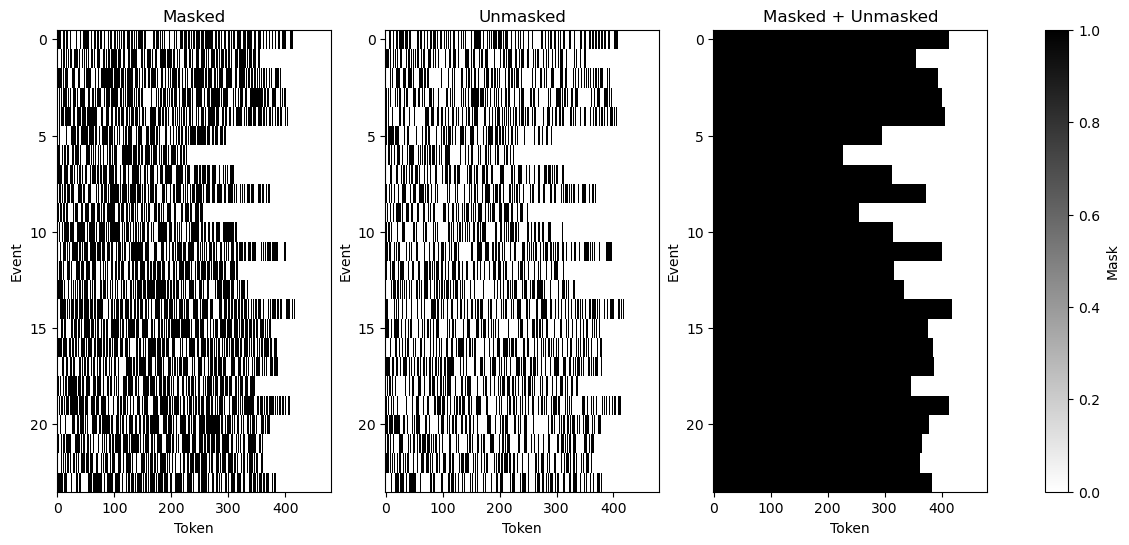

In [32]:
import matplotlib.pyplot as plt

# plot masked and unmasked masks for first event side by side in same figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

ax1.imshow(masked.cpu().numpy(), aspect='auto', cmap='gray_r', interpolation='none')
ax1.set_title('Masked')

ax2.imshow(unmasked.cpu().numpy(), aspect='auto', cmap='gray_r', interpolation='none')
ax2.set_title('Unmasked')

ax3.imshow(embedding_mask.cpu().numpy(), aspect='auto', cmap='gray_r', interpolation='none')
ax3.set_title('Masked + Unmasked')

cbar = fig.colorbar(ax3.images[0], ax=[ax1, ax2, ax3])
cbar.set_label('Mask')

ax1.set_xlabel('Token')
ax1.set_ylabel('Event')
ax2.set_xlabel('Token')
ax2.set_ylabel('Event')
ax3.set_xlabel('Token')
ax3.set_ylabel('Event')
plt.show()

In [42]:
w_m = masked.unsqueeze(-1)   # (B, T, 1)
w_u = unmasked.unsqueeze(-1) # (B, T, 1)

# Get positional encodings for centers
pos = positional_encoding(centers[..., :3])


# Get visible embeddings
visible_embeddings = w_u * embeddings

# Pass visible embeddings through encoder
# w_u is used to create the correct attention mask to ensure the encoder only attends to visible tokens
# and not masked/padded tokens
encoder_output = encoder(visible_embeddings, pos, w_u.bool().squeeze()).last_hidden_state

# Decoder mask == embedding_mask (i.e. attend to all non-padded tokens)
decoder_mask = embedding_mask


# Replace visible tokens in corrupted embeddings with encoder output
total_embeddings = encoder_output * w_u + w_m * mask_token

# Pass total embeddings through decoder
decoder_output = decoder(total_embeddings, pos, decoder_mask).last_hidden_state

# Get masked output embeddings
masked_output_embeddings = decoder_output[masked]

# Regress 4D points from masked output embeddings
regressed_points = model.increase_dim(masked_output_embeddings.transpose(0, 1)).transpose(0, 1)
regressed_points = regressed_points.reshape(regressed_points.shape[0], -1, model.hparams.num_channels)

ground_truth_points = groups[masked]

print(regressed_points.shape, ground_truth_points.shape)

torch.Size([5166, 32, 4]) torch.Size([5166, 32, 4])


We now have the regressed points and the ground truth points. We can now compute the Chamfer Distance between the two. However, since the patches contain a variable number of points, we need to pass the actual lengths of each patch to the Chamfer Distance function.

In [46]:
from pytorch3d.loss import chamfer_distance

point_lengths = point_mask[masked].sum(-1)

chamfer_loss, _ = chamfer_distance(
    regressed_points,
    ground_truth_points,
    x_lengths=point_lengths,
    y_lengths=point_lengths,
)

print(chamfer_loss)

tensor(0.6254, device='cuda:0')
